# Pré-processamento de Imagens: Redimensionamento e Conversão para Escala de Cinza

Nessa etapa, vai ser realizado duas operações principais em uma imagem do dataset para as letras A, B e C:

1. **Redimensionamento das Imagens**: Todas as imagens serão redimensionadas para um tamanho fixo de `200x200 px` para ter uma consistência na análise posterior.
2. **Conversão para Escala de Cinza**: As imagens coloridas serão convertidas para **escala de cinza** para simplificar a análise, removendo as informações de cor.

## Passos:

1. **Leitura das Imagens**: As imagens de cada letra (A, B, C) foram lidas a partir da pasta correspondente.
2. **Redimensionamento**: Cada imagem foi redimensionada para `200x200 px` usando o OpenCV.
3. **Conversão para Escala de Cinza**: As imagens foram convertidas para escala de cinza para reduzir a complexidade e facilitar o processamento posterior.

=== Verificação do Dataset ===
Letra A: 10 imagens
Letra B: 5 imagens
Letra C: 5 imagens

Total de imagens a processar: 20

=== Iniciando Processamento ===
Processando: dataset/A/hand1_a_dif_seg_2_cropped.jpeg


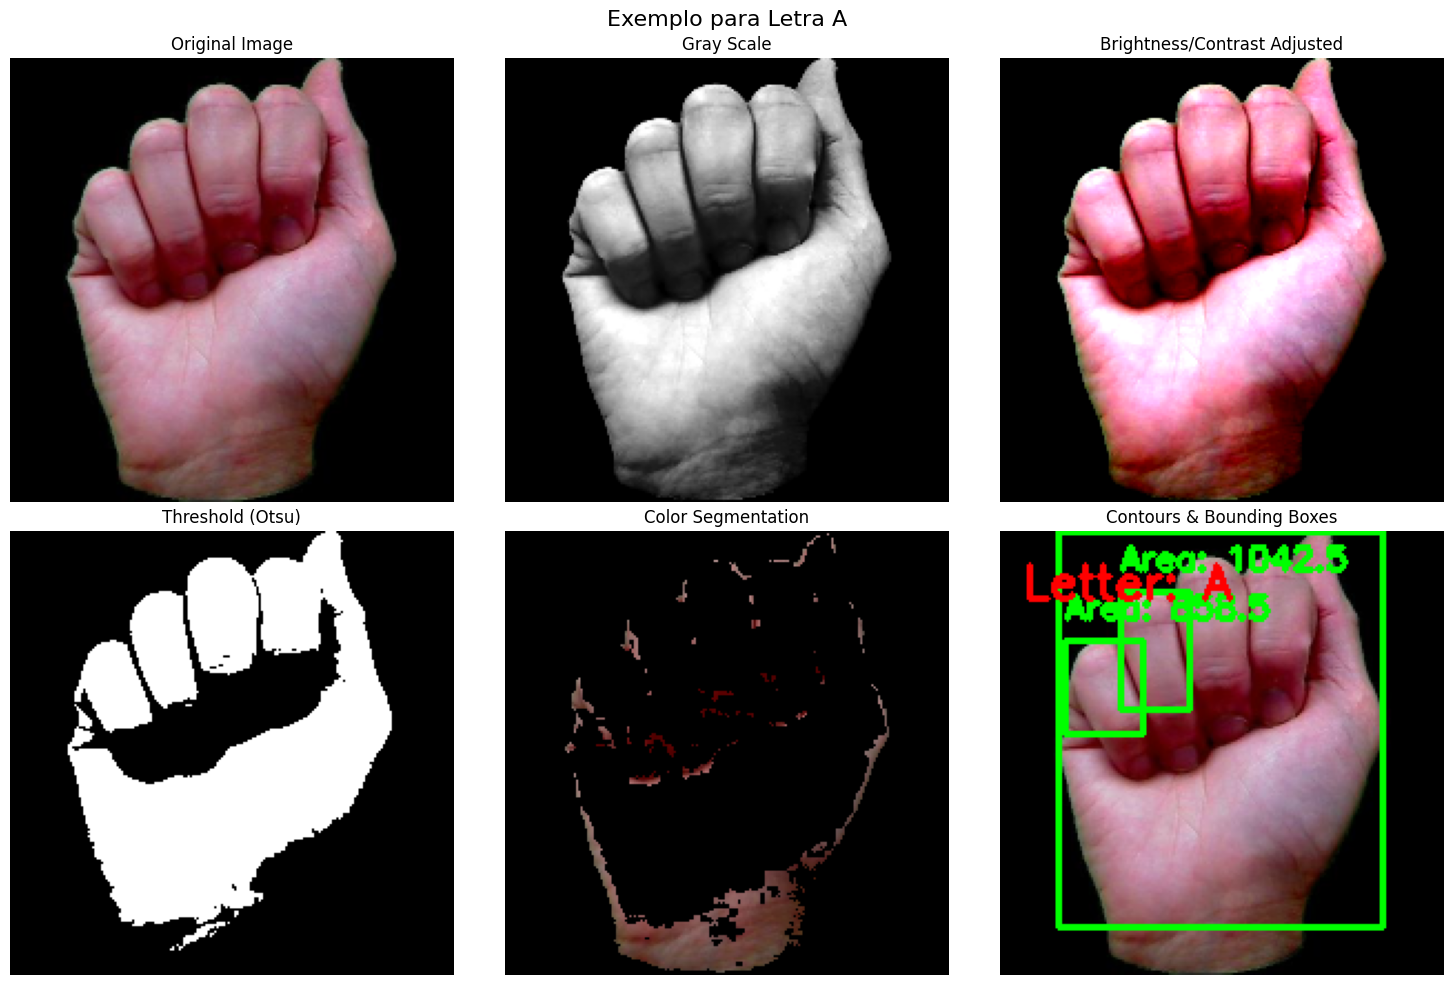

Processando: dataset/A/hand1_a_dif_seg_5_cropped.jpeg
Processando: dataset/A/hand1_a_dif_seg_3_cropped.jpeg
Processando: dataset/A/hand1_a_bot_seg_2_cropped.jpeg
Processando: dataset/A/hand1_a_bot_seg_3_cropped.jpeg
Processando: dataset/A/hand1_a_dif_seg_4_cropped.jpeg
Processando: dataset/A/hand1_a_bot_seg_1_cropped.jpeg
Processando: dataset/A/hand1_a_bot_seg_4_cropped.jpeg
Processando: dataset/A/hand1_a_bot_seg_5_cropped.jpeg
Processando: dataset/A/hand1_a_dif_seg_1_cropped.jpeg
Processando: dataset/B/hand1_b_bot_seg_2_cropped.jpeg


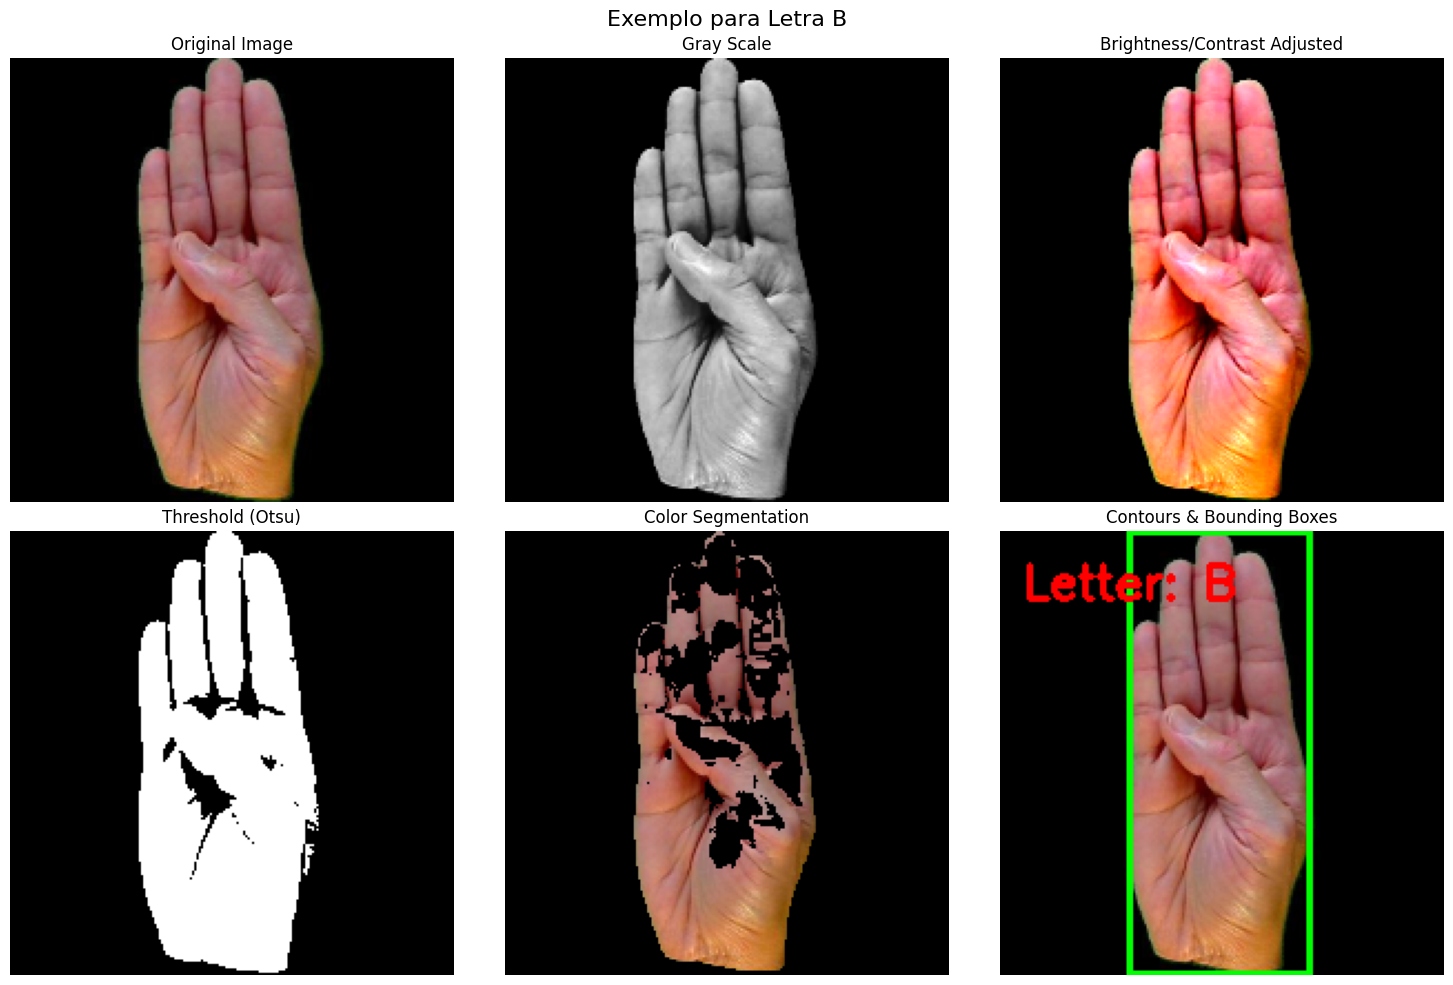

Processando: dataset/B/hand1_b_bot_seg_1_cropped.jpeg
Processando: dataset/B/hand1_b_bot_seg_5_cropped.jpeg
Processando: dataset/B/hand1_b_bot_seg_3_cropped.jpeg
Processando: dataset/B/hand1_b_bot_seg_4_cropped.jpeg
Processando: dataset/C/hand1_c_bot_seg_1_cropped.jpeg


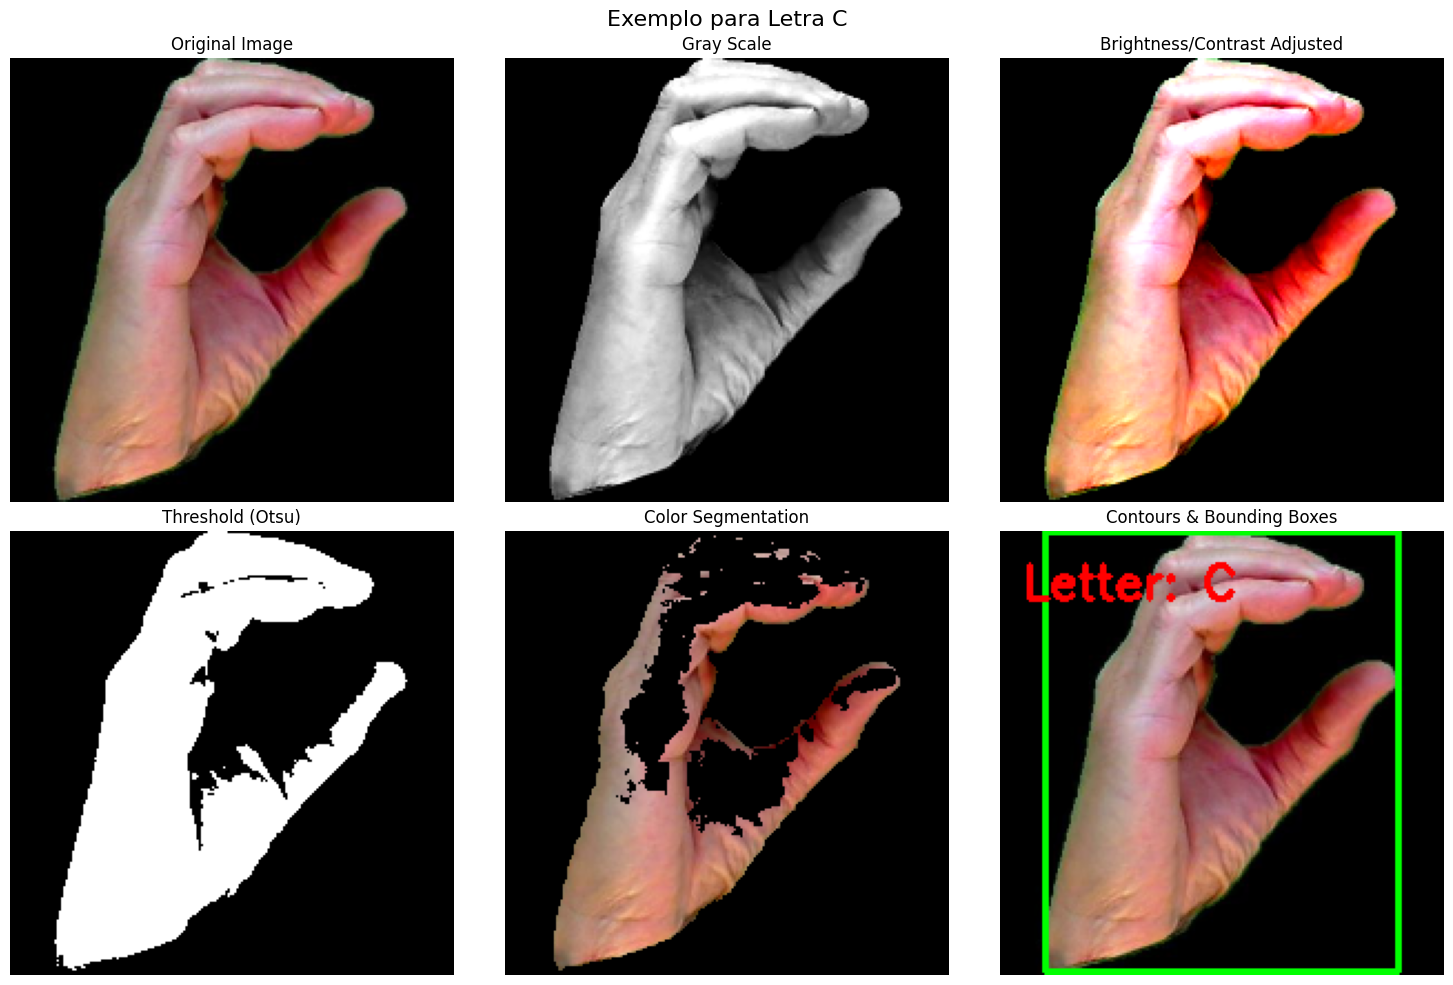

Processando: dataset/C/hand1_c_bot_seg_3_cropped.jpeg
Processando: dataset/C/hand1_c_bot_seg_2_cropped.jpeg
Processando: dataset/C/hand1_c_bot_seg_4_cropped.jpeg
Processando: dataset/C/hand1_c_bot_seg_5_cropped.jpeg

Processamento concluído! Todas as imagens foram salvas em: images_result/processed


In [16]:
import cv2
import os
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# Configuração dos paths
base_path = Path("dataset")
letters = ['A', 'B', 'C']
output_path = Path("images_result")
output_path.mkdir(parents=True, exist_ok=True)
(output_path / 'processed').mkdir(parents=True, exist_ok=True)

# Função para criar e salvar o grid combinado
def save_combined_plot(processed_imgs, letter, output_dir, img_name):
    """Cria e salva uma imagem combinada com todos os subplots"""
    plt.figure(figsize=(15, 10))
    
    subplots = [
        {'key': 'original', 'title': 'Original Image', 'cmap': None},
        {'key': 'gray', 'title': 'Gray Scale', 'cmap': 'gray'},
        {'key': 'adjusted', 'title': 'Brightness/Contrast Adjusted', 'cmap': None},
        {'key': 'threshold', 'title': 'Threshold (Otsu)', 'cmap': 'gray'},
        {'key': 'color_seg', 'title': 'Color Segmentation', 'cmap': None},
        {'key': 'with_boxes', 'title': 'Contours & Bounding Boxes', 'cmap': None}
    ]
    
    for i, plot in enumerate(subplots, start=1):
        plt.subplot(2, 3, i)
        img = processed_imgs[plot['key']]
        if plot['cmap'] is None and len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img, cmap=plot['cmap'])
        plt.title(plot['title'])
        plt.axis('off')
    
    plt.suptitle(f'Processamento para Letra {letter} - {img_name}', fontsize=16)
    plt.tight_layout()
    output_file = output_dir / f'{letter}_{img_name}_combined.png'
    plt.savefig(str(output_file), bbox_inches='tight', dpi=100)
    plt.close()

# Funções de processamento (mantidas as mesmas)
def adjust_brightness_contrast(img, brightness=0, contrast=0):
    brightness = brightness * 2.55
    contrast = contrast * 2.55
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha = (highlight - shadow)/255
        gamma = shadow
        img = cv2.addWeighted(img, alpha, img, 0, gamma)
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        img = cv2.addWeighted(img, alpha_c, img, 0, gamma_c)
    
    return img

def apply_thresholding(img, method='otsu'):
    if method == 'otsu':
        _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif method == 'adaptive':
        thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                      cv2.THRESH_BINARY, 11, 2)
    else:
        _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    return thresh

def color_segmentation_hsv(img, lower_hsv, upper_hsv):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_hsv, upper_hsv)
    result = cv2.bitwise_and(img, img, mask=mask)
    return result, mask

def find_contours_and_draw_boxes(img, original_img=None, min_area=500):
    img_with_boxes = original_img.copy() if original_img is not None else img.copy()
    if len(img_with_boxes.shape) == 2:
        img_with_boxes = cv2.cvtColor(img_with_boxes, cv2.COLOR_GRAY2BGR)
    
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > min_area:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(img_with_boxes, f'Area: {area}', (x, y-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return img_with_boxes

def resize(path_img):
    img = cv2.imread(str(path_img))
    img_resize = cv2.resize(img, (200, 200))
    return img_resize

def to_gray_scale(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

def process_img(path_img, letter):
    img_resized = resize(path_img)
    img_adjusted = adjust_brightness_contrast(img_resized.copy(), brightness=10, contrast=20)
    img_gray = to_gray_scale(img_adjusted.copy())
    img_thresh = apply_thresholding(img_gray.copy(), method='otsu')
    
    lower_skin = np.array([0, 48, 80], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)
    img_color_seg, mask_color = color_segmentation_hsv(img_resized.copy(), lower_skin, upper_skin)
    
    img_with_boxes = find_contours_and_draw_boxes(img_thresh.copy(), img_resized.copy())
    cv2.putText(img_with_boxes, f'Letter: {letter}', (10, 30), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    return {
        'original': img_resized,
        'gray': img_gray,
        'adjusted': img_adjusted,
        'threshold': img_thresh,
        'color_seg': img_color_seg,
        'color_mask': mask_color,
        'with_boxes': img_with_boxes
    }

# Verificação inicial do dataset
print("=== Verificação do Dataset ===")
total_imgs = 0
for letter in letters:
    dir = base_path / letter
    count = len(os.listdir(dir))
    print(f"Letra {letter}: {count} imagens")
    total_imgs += count
print(f"\nTotal de imagens a processar: {total_imgs}\n")

# Processamento principal
print("=== Iniciando Processamento ===")
example_shown = {letter: False for letter in letters}  # Controla exemplos mostrados

for letter in letters:
    dir = base_path / letter
    
    for img_file in os.listdir(dir):
        img_path = dir / img_file
        img_name = os.path.splitext(img_file)[0]
        
        print(f"Processando: {img_path}")
        processed_imgs = process_img(img_path, letter)
        
        # Salva o grid combinado
        save_combined_plot(processed_imgs, letter, output_path / 'processed', img_name)
        
        # Mostra apenas o primeiro exemplo de cada letra
        if not example_shown[letter]:
            plt.figure(figsize=(15, 10))
            
            # Recria os subplots para exibição
            subplots = [
                {'key': 'original', 'title': 'Original Image', 'cmap': None},
                {'key': 'gray', 'title': 'Gray Scale', 'cmap': 'gray'},
                {'key': 'adjusted', 'title': 'Brightness/Contrast Adjusted', 'cmap': None},
                {'key': 'threshold', 'title': 'Threshold (Otsu)', 'cmap': 'gray'},
                {'key': 'color_seg', 'title': 'Color Segmentation', 'cmap': None},
                {'key': 'with_boxes', 'title': 'Contours & Bounding Boxes', 'cmap': None}
            ]
            
            for i, plot in enumerate(subplots, start=1):
                plt.subplot(2, 3, i)
                img = processed_imgs[plot['key']]
                if plot['cmap'] is None and len(img.shape) == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img, cmap=plot['cmap'])
                plt.title(plot['title'])
                plt.axis('off')
            
            plt.suptitle(f'Exemplo para Letra {letter}', fontsize=16)
            plt.tight_layout()
            plt.show()
            example_shown[letter] = True

print("\nProcessamento concluído! Todas as imagens foram salvas em:", output_path / 'processed')